In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import corner

from glob import glob
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [2]:
# Locations with posteriors and to save figures.
post_path = '../Posteriors/'
fig_path = '../figures/'

if not os.path.isdir(fig_path):
    os.makedirs(fig_path)

sns.set_theme(style="ticks", context="talk")

columnwidth = 3.37574803 

In [3]:
# Files to do corner plots for.
files = sorted(glob(post_path + "chime-frb_SDSS*.nc"))
files

['../Posteriors/chime-frb_SDSS_124_zs_20x1500_draws.nc',
 '../Posteriors/chime-frb_SDSS_random_sample_of_124_zs_run_0_20x1500_draws.nc',
 '../Posteriors/chime-frb_SDSS_random_sample_of_124_zs_run_1_20x1500_draws.nc',
 '../Posteriors/chime-frb_SDSS_random_sample_of_124_zs_run_2_20x1500_draws.nc']

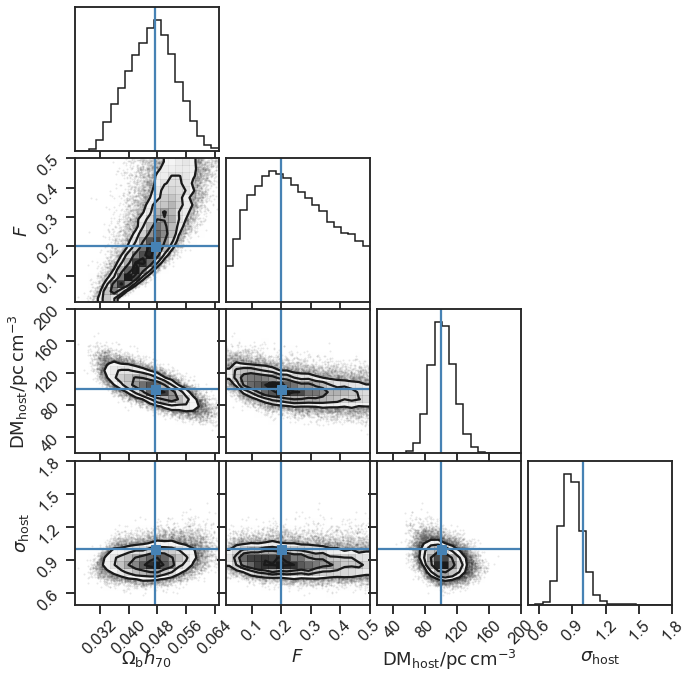

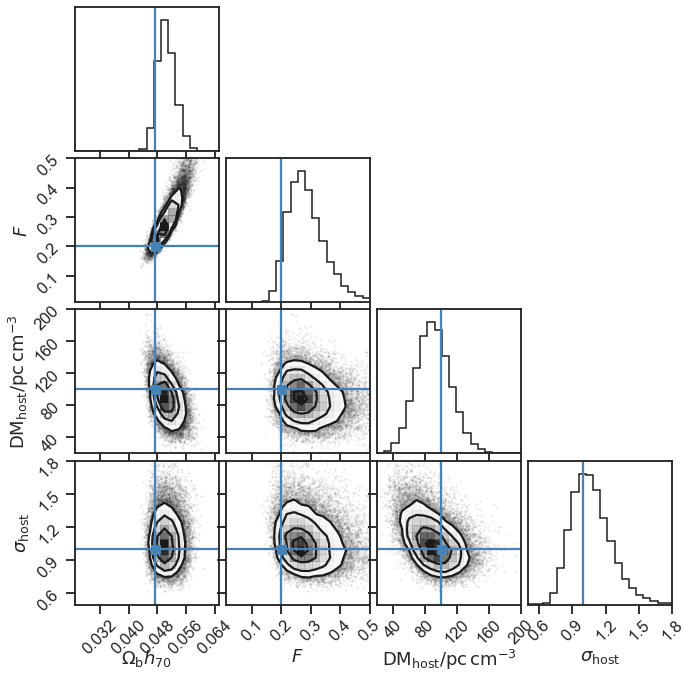

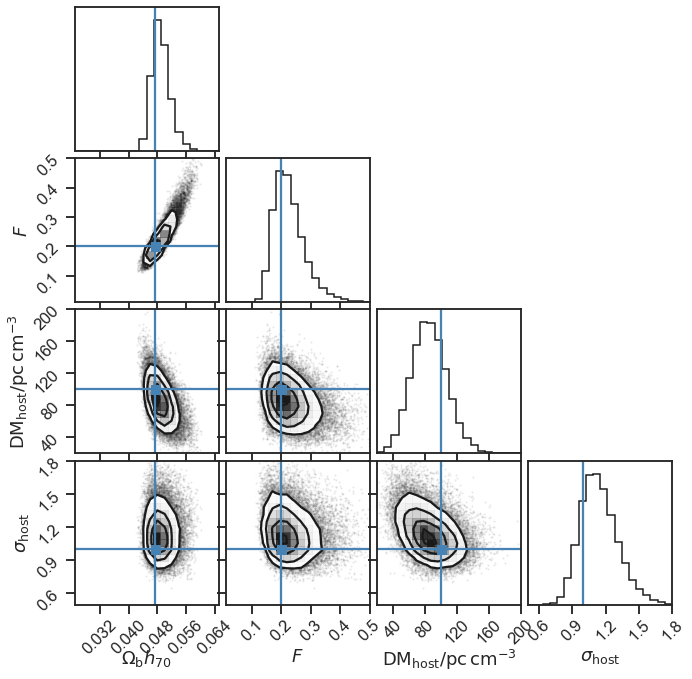

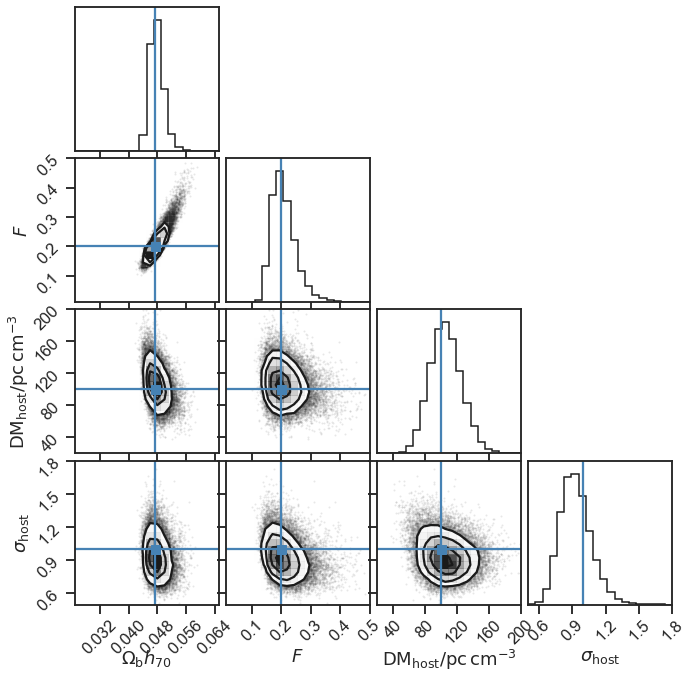

In [4]:
# Set fiducial parameters for comparison
Obh70, F, mu, lognorm_s = cosmo.Ob0*cosmo.H0.value/70, .2, 100, 1

# Do corner plots of some posteriors
for file in files[:]:
    idata = az.from_netcdf(file)
    
    # fig = plt.figure(figsize=(columnwidth, columnwidth))
    fig = corner.corner(idata, color='k', 
                        var_names=['Obh70', 'F', 'mu', 'lognorm_s'], 
                        labels=['$\Omega_\mathrm{b} h_{70}$', '$F$', r'$\mathrm{DM}_\mathrm{host}/\mathrm{pc}\,\mathrm{cm}^{-3}$', '$\sigma_\mathrm{host}$'],
                        range=[(0.025, 0.065), (0.011, .5), (20, 200), (0.5, 1.8)],  # CHIME + SDSS
                        # range=[(0.038, 0.055), (0.1, .5), (60, 160), (0.6, 1.2)],  # ASKAP + DELVE
                        truths=[Obh70, F, mu, lognorm_s])
    
    # Set some ticks manually (to prevent them from getting too long).
    # fig.get_axes()[4].set_yticks(np.arange(3, 7)*0.01)
    # fig.get_axes()[-3].set_xticks(np.arange(3, 7)*0.01)
    
    fig.savefig(fig_path + f"{os.path.splitext(os.path.basename(file))[0]}.png", dpi=300, bbox_inches='tight')


In [5]:
# Calculate the ratio of the observed FRB constrains with the randomly drawn FRBs.
idata = az.from_netcdf(post_path + 'chime-frb_SDSS_124_zs_20x1500_draws.nc')
hdi95 = az.hdi(idata.posterior, hdi_prob=0.95).to_array().to_pandas()
hdi95_diff = hdi95.loc[:, 'higher']-hdi95.loc[:, 'lower']
idata = az.from_netcdf(post_path + 'chime-frb_SDSS_random_sample_of_124_zs_run_1_20x1500_draws.nc')
hdi95 = az.hdi(idata.posterior, hdi_prob=0.95).to_array().to_pandas()
hdi95_diff_rnd = hdi95.loc[:, 'higher']-hdi95.loc[:, 'lower']
hdi95_diff/hdi95_diff_rnd

variable
Obh70        2.564859
F            2.180576
mu           0.681348
lognorm_s    0.543266
dtype: float64

In [6]:
# Files for which to plot the credible intervals.
files = sorted(glob(post_path + 'askap-craco_DES_[0-9]*.nc'))
files

['../Posteriors/askap-craco_DES_101_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_10_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_116_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_11_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_133_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_13_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_153_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_15_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_175_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_17_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_19_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_201_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_22_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_230_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_264_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_26_zs_20x1500_draws.nc',
 '../Posteriors/askap-craco_DES_29_zs_20x1500_draws.nc',
 '../Posteriors/askap-c

In [7]:
# Calculate the 95% credible interval.
quantiles = []
hdi95 = []
n_frbs = np.zeros(len(files), dtype=int)
for i, post_path in enumerate(files):
    n_frbs[i] = os.path.split(post_path)[-1].split('_')[2]
    idata = az.from_netcdf(post_path)
    quantiles.append(idata.posterior.quantile([.05, .5, .95]).to_array().to_pandas())
    hdi95.append(az.hdi(idata.posterior, hdi_prob=0.95).to_array().to_pandas())

quantiles = pd.concat(quantiles, axis=0)
hdi95 = pd.concat(hdi95, axis=0)

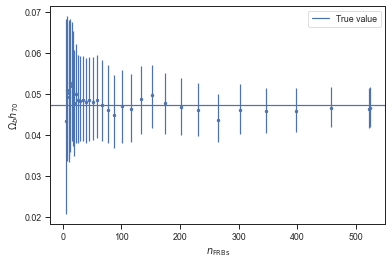

In [8]:
sns.set_theme(style="ticks", context="paper")

# Plot the constraints on the baryon density against the number of FRBs.
var, true_val = 'Obh70', Obh70
median = quantiles.loc[var, 0.5]
plt.errorbar(n_frbs, median, 
             yerr=pd.concat([median-hdi95.loc[var, 'lower'], hdi95.loc[var, 'higher']-median], axis=1).to_numpy().T, 
             fmt='.')

plt.axhline(true_val, label="True value")

plt.xlabel("$n_\mathrm{FRBs}$")
plt.ylabel('$\Omega_b h_{70}$')
#plt.xscale('log')
plt.legend()
# plt.savefig(fig_path + "Obh_vs_nFRBs.png", dpi=300, bbox_inches='tight')
plt.show()

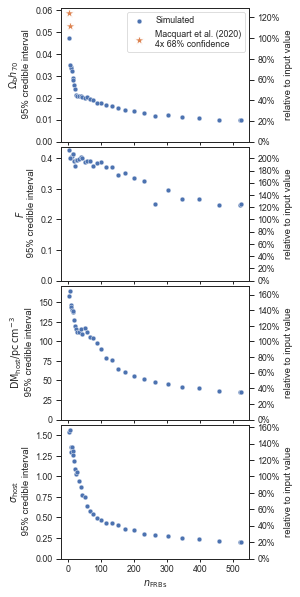

In [9]:
# Show the evolution of all 4 parameters with the FRB number (Fig.7 of the paper).
fig, axs = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace':0.04}, figsize=(columnwidth, 4*columnwidth/6.4*4.8))
for ax, var, true_val, plot_name in zip(axs, ['Obh70', 'F', 'mu', 'lognorm_s'], [Obh70, F, mu, lognorm_s],
        ['$\Omega_\mathrm{b} h_{70}$', '$F$', r'$\mathrm{DM}_\mathrm{host}/\mathrm{pc}\,\mathrm{cm}^{-3}$', 
         '$\sigma_\mathrm{host}$']):
    # fig, ax = plt.subplots()
    # Plot credible intervals against FRB numbers.
    hdi95_diff = hdi95.loc[var, 'higher']-hdi95.loc[var, 'lower']
    #mean_hdi = hdi95_diff / 2
    sns.scatterplot(x=n_frbs, y=hdi95_diff, label="Simulated", ax=ax, legend=False)
    #plt.plot(n_frbs, median-hdi95.loc[var, 'lower'], '.', label="Simulated")

    if var == 'Obh70':
        # Macquarts results
        rel_uncert = np.array([.31, .28])
        abs_uncert = np.array([.014+.015, .011+.012])
        sns.scatterplot(x=[5, 7], y=rel_uncert*Obh70*2*2, ax=ax, label="Macquart et al. (2020)\n4x 68% confidence", marker='*', s=100) #abs_uncert
        ax.legend()

    # Fit 1/sqrt function.
    # popt, pcov = curve_fit(lambda x, a: a/np.sqrt(x), n_frbs, hdi95_diff)
    # x = np.logspace(np.log10(4), np.log10(700), 30)
    # plt.plot(x, popt[0]/np.sqrt(x), zorder=.1, label=f"{popt[0]:2.2}"+"$/\sqrt{n_\mathrm{FRBs}}$")

    ax.set_ylabel(f"{plot_name}\n 95% credible interval")
    ax.set_ylim(0, None)
    ax.xaxis.set_tick_params(length=3)

    # Put a percent axis on the right
    # ax = plt.gca()
    ax2 = ax.twinx()
    y2_minmax = np.array(ax.get_ylim())/true_val*100
    ax2.set_ylim(y2_minmax)
    y2ticks = np.arange(*y2_minmax, 20, dtype=int)
    ax2.set_yticks(y2ticks, labels=[str(tick)+"%" for tick in y2ticks])
    ax2.set_ylabel("relative to input value")

ax.set_xlabel("$n_\mathrm{FRBs}$")
plt.savefig(fig_path + f"ASKAP-DES_95ci_vs_nFRBs.png", dpi=300, bbox_inches='tight')
plt.show()